<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_SST_file_structure.ipynb" target="_blank"><< Exploring OSI SAF SST product structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_SST_mapping_Global_Metop_SST.ipynb" target="_blank">Mapping Global Metop AVHRR SST products >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sst_introductory%2F1_3a_OSI_SAF_SST_mapping_Metop_Metagranules.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_OSI_SAF_SST_data_access_IFREMER_Opensearch.ipynb" target="_blank">1_1a_OSI_SAF_SST_data_access_IFREMER_Opensearch.ipynb</a>**
</div>
<hr>

# 1.3a Mapping Metop SST Metagranules

### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Full resolution Metop-B Sea Surface Temperature metagranules | EO:EUM:DAT:METOP:MGR-SST | <a href="https://osi-saf.eumetsat.int/products/osi-204-b" target="_blank">Description</a>| OSI-204-b | 
| Full resolution Metop-C Sea Surface Temperature metagranules | EO:EUM:DAT:METOP:MGR-SST | <a href="https://osi-saf.eumetsat.int/products/osi-204-c" target="_blank">Description</a>| OSI-204-c | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Metop SST netcdf metagranules
* Map SST using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Defining geographical area](#section1)
 1. [Setting parameters](#section2)
 1. [Map SST](#section3)
 
<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import numpy as np                 # a library that supports array manipulation
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_sst` create a plot figure of sea surface temperature of the sst product available in the directory **dir** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_sst(dir, output_projection, cmap, ax=None, title="", region=None): 
    """
    Function to map Sea Surface Temperature. 

    Args:
        dir (string)        : the directory where files are
        output_projection   : the output projection to plot map
        cmap                : color palette
        ax                  : the axis of the plot
        title (sting)       : title of the plot
        region (list)       : the region to zoom in. If not region is given, plot a global map
        
    Returns:
        im                  : the plotting figure

    """
    
    # set data projection
    data_projection=ccrs.PlateCarree()
    
    # define plot carateristics
    if not ax : ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey') # Change color of land
    ax.gridlines(draw_labels=True) # Add coasrline
    ax.coastlines('10m') # Draw coastline
    # Select region to zooming 
    if region : 
        ax.set_extent(region, crs=output_projection)
    else :
        ax.set_global()
    
    # Add title
    plt.title(title, fontsize=18)

    # open and plot data
    for filename in os.listdir(dir):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(dir, filename))
            lat = nc.variables['lat'][:]    
            lon = nc.variables['lon'][:]
            sst = nc.variables['sea_surface_temperature'][:]
            ql  = nc.variables['quality_level'][:]
            nc.close()

            # Use only SST with quality_level > 2
            sst_ql345 = np.ma.masked_where(ql<3, sst)
            
            SST = sst_ql345[0,:,:]-273.15
            # plotting sst
            im = plt.pcolormesh(lon, lat, SST, transform=data_projection, cmap=cmap)

            # set the min and max temperature for apropriate visualisation
            im.set_clim(np.nanmin(SST),np.nanmax(SST))
            
    return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('SST [°C]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Defining geographical area
[Back to top](#TOC-TOP)

</div>

This first section allows to set the geographical area corresponding to the zone of interest we have downloaded granules for.

In [4]:
# setting geographical area
lon_min = 6
lon_max = 45
lat_min = -39
lat_max = -14

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Setting parameters
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [5]:
directory = os.path.join(os.getcwd(), 'products', 'metagranules')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [6]:
cmap = mpl_cm.get_cmap('RdYlBu_r')
cmap = mpl_cm.get_cmap('inferno')

#cmap = cmocean.cm.thermal

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Map SST
[Back to top](#TOC-TOP)

</div>

Mapping figure based on retrieved metagranules

#### Plate Carree

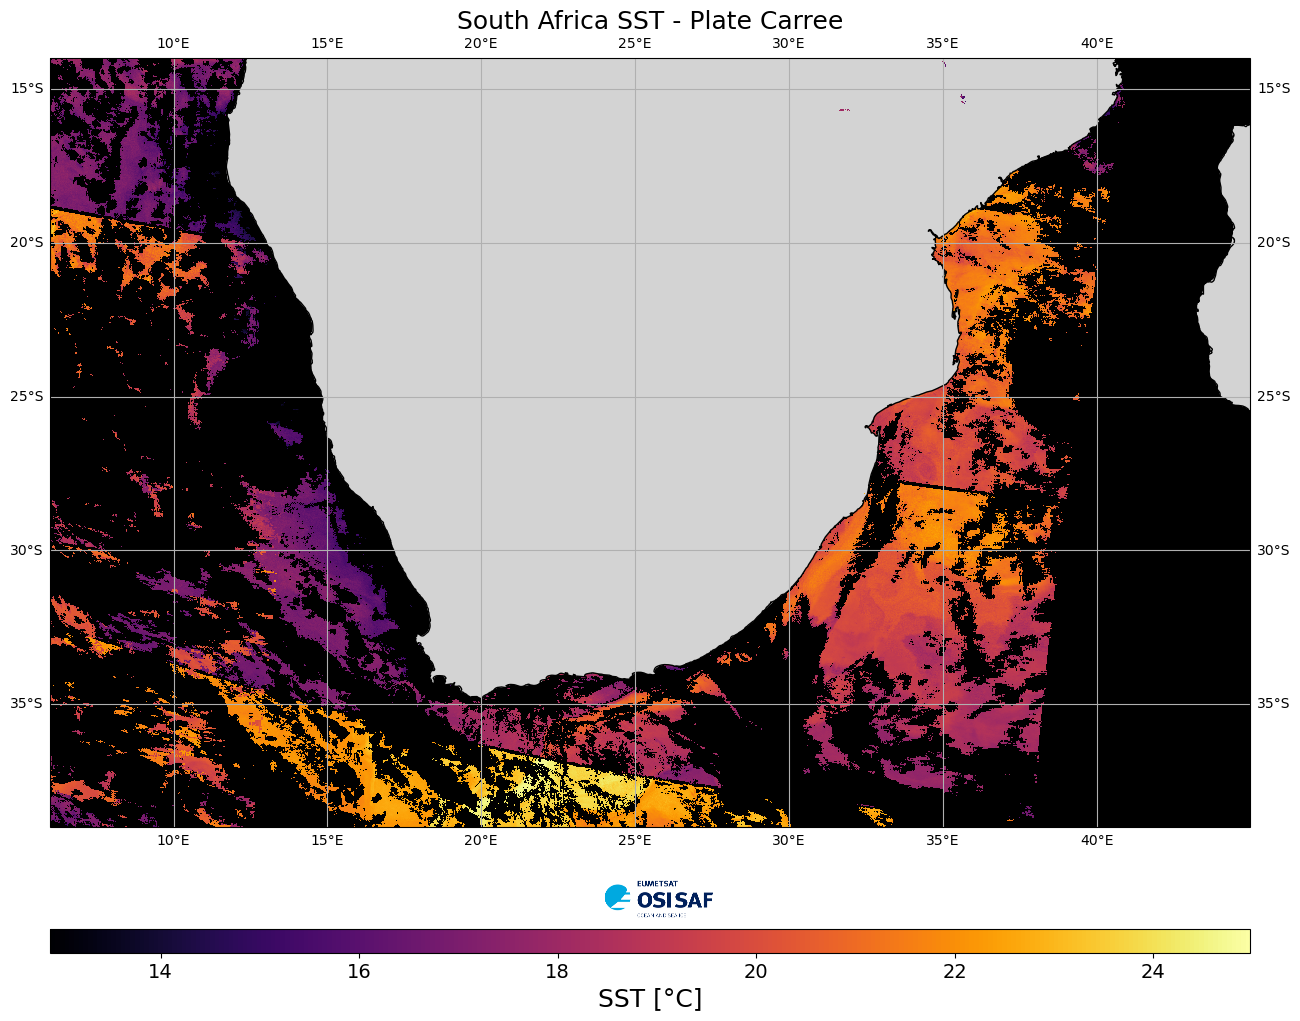

In [7]:
fig = plt.figure(figsize=(16,12))

# request output projection
output_projection=ccrs.PlateCarree()

# define axis and title
title = "South Africa SST - Plate Carree"

# Mapping sst
im = mapping_sst(directory,
                 output_projection, 
                 cmap,
                 title=title, 
                 region=[lon_min,lon_max,lat_min,lat_max])

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)
        

#### Map projection
Other type of projections can be used to visualize SST products. All the map projections are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documentation</a> 

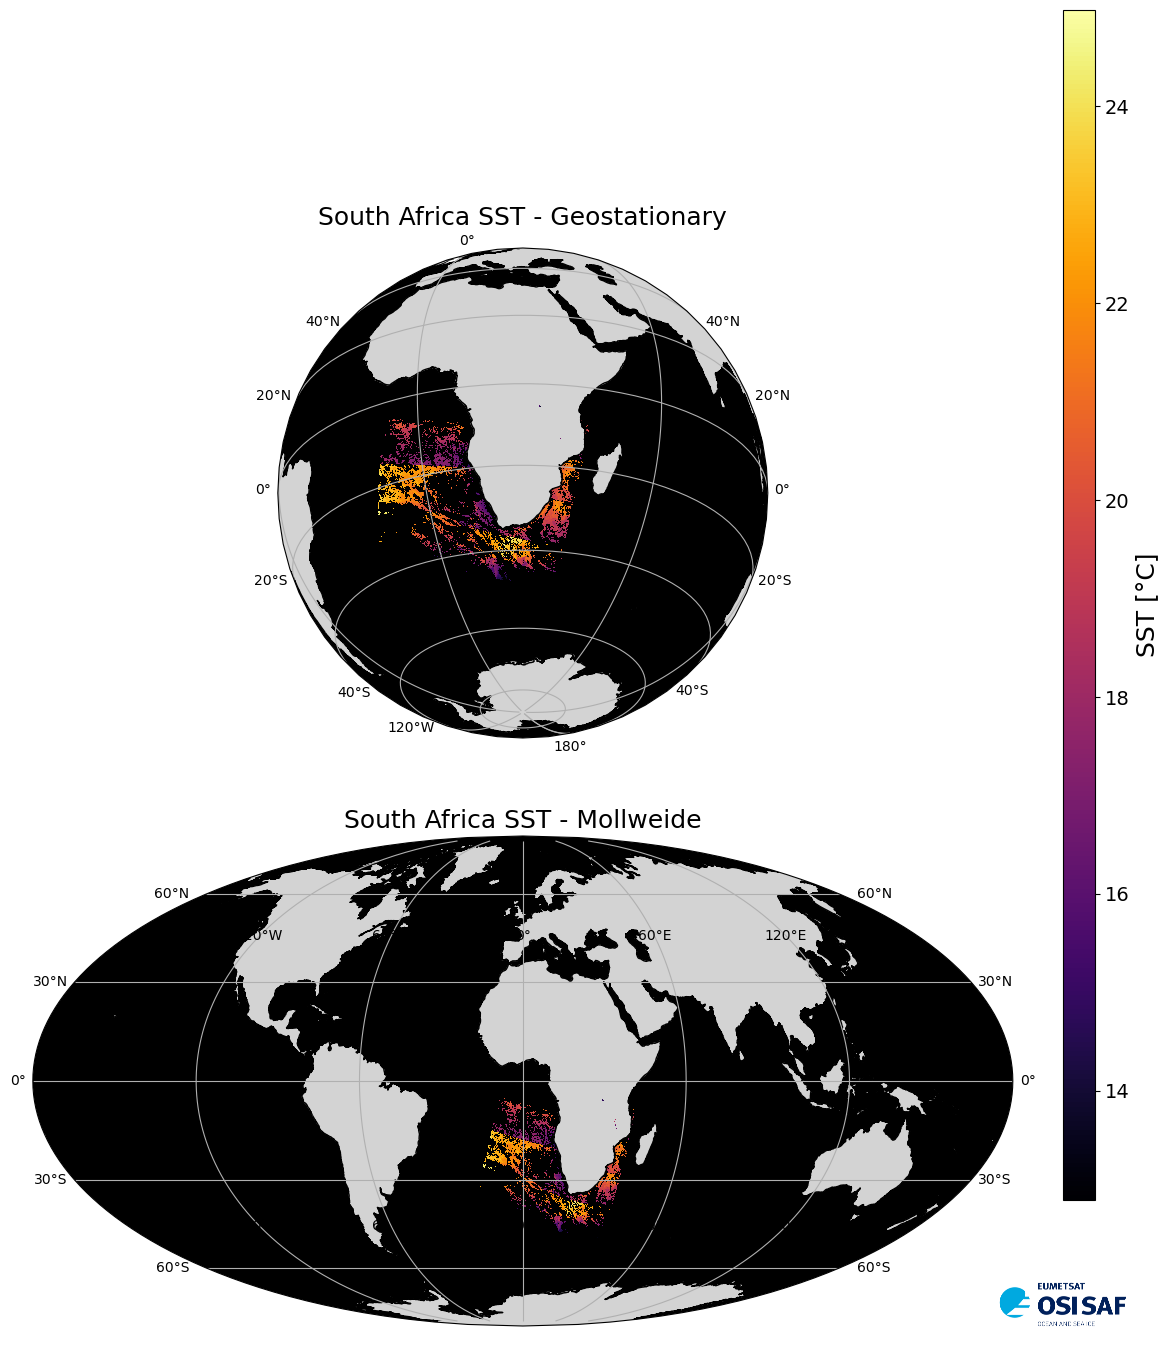

In [8]:
fig = plt.figure(figsize=(16,14))

# request output projection
output_projection1 = ccrs.Orthographic((lon_max+lon_min)/2,(lat_max+lat_min)/2)
output_projection2 = ccrs.Mollweide(central_longitude=0,)

# define axis and title
ax1 = plt.subplot(2,1,1, projection=output_projection1)
title1 = "South Africa SST - Geostationary"
# Mapping sst
im1 = mapping_sst(directory, 
                 output_projection1, 
                 cmap,
                 ax=ax1,
                 title=title1)

# define axis and title
ax2 = plt.subplot(2,1,2, projection=output_projection2)
title2 = "South Africa SST - Mollweide"
# Mapping sst
im2 = mapping_sst(directory,  
                 output_projection2, 
                 cmap,
                 ax=ax2,
                 title=title2) 

add_colorbar(im1, fig, orientation="vertical", cmap=cmap)

#### Visualisation
We will create an new file to isolate one metagranule and visualising it alone.

In [9]:
directory = os.path.join(os.getcwd(), "products", "metagranules", "one")

Using  the left pannel of the notebook, you can now go to the folder `products/metagranules`, create a `one` subfolder and clic an drop one file into the folder `one` .

We will now map this single metagranule on a map of south africa.

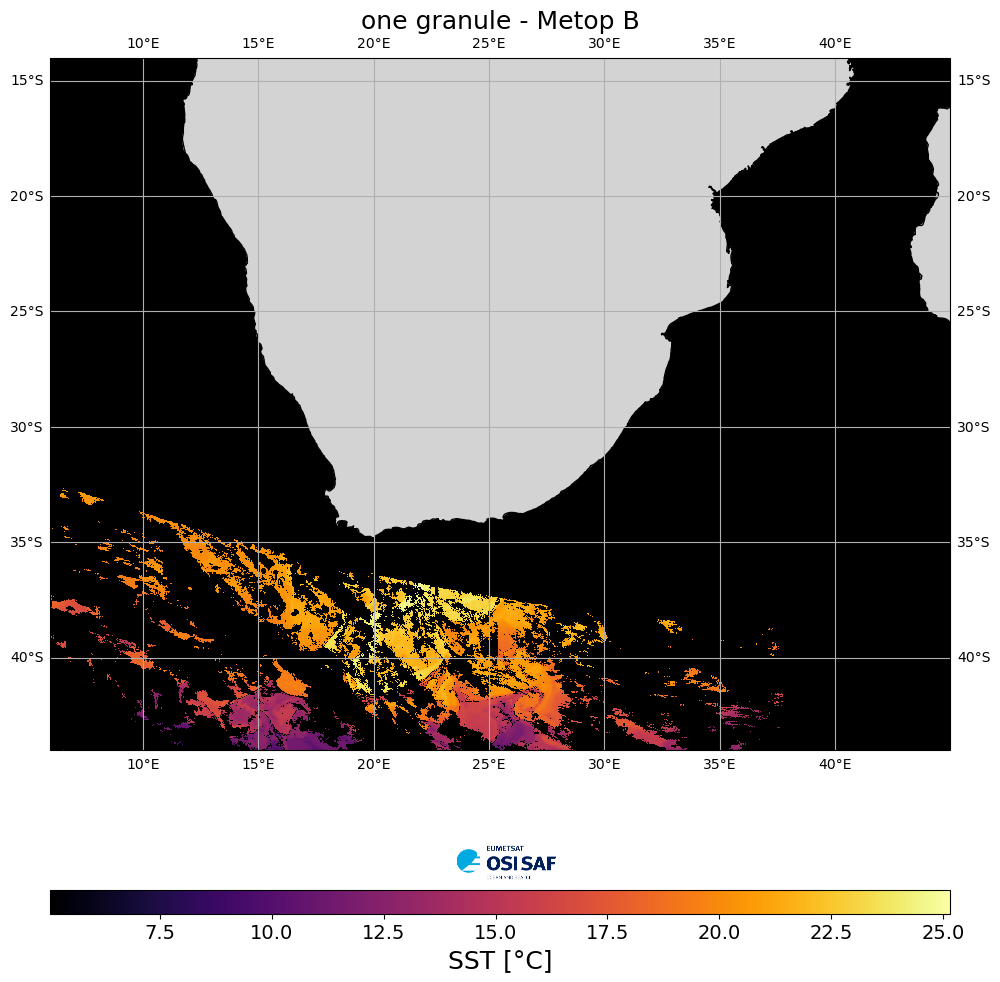

In [12]:
fig = plt.figure(figsize=(12,12))

# request output projection
output_projection=ccrs.PlateCarree()

# define axis and title
title = "one granule - Metop B"

# Mapping sst
im = mapping_sst(directory,
                 output_projection, 
                 cmap,
                 title=title,
                 region=[lon_min,lon_max,lat_min-5,lat_max])

add_colorbar(im, fig, orientation="horizontal", cmap=cmap)
        

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2c_OSI_SAF_SST_IST_High_Latitudes_file_structure.ipynb" target="_blank"><< Exploring OSI SAF SST product structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_SST_mapping_Global_Metop_SST.ipynb" target="_blank">Mapping Global Metop AVHRR SST products >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>